In [1]:
"""
-*- coding: utf-8 -*-
Created on Fri 21 2020
@author: Thiago Pinho
"""

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import spacy
from spacy.lang.pt import Portuguese
from spacy.lang.pt.stop_words import STOP_WORDS
from unidecode import unidecode
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from string import punctuation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from preprocessing import generate_freq_dist_plot, generate_wordcloud

## Constants
For better code management, the constants used in this notebook will be listed bellow.

In [2]:
VECTOR_MODEL_NAME = "pt_core_news_sm"
RELATIVE_PATH_TO_FOLDER = "./assets/datasets/ribon/"
DATA_FILENAME = "feeds_label"
NLP_SPACY = spacy.load(VECTOR_MODEL_NAME)
TARGET_VARIABLE = "LABEL_TRAIN"
POSSIBLE_TEXT_VARIABLES = ["CONTENT", "TITLE"]

## Load raw data and start to treat the it's structure
We'll have a first look at the raw data and after analysing it's structure we can fix missing values(By dropping or artificially inserting then). We can encode or adjust categorical data if needed, fix column names and also drop unnused colummns.

In [3]:
"""  load the dataset """
relative_path_file = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + ".csv"
df_ribon_news = pd.read_csv(relative_path_file)
print(df_ribon_news.info())
print()
print(df_ribon_news['Label_Train'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           888 non-null    int64 
 1   pick_count   888 non-null    int64 
 2   content      886 non-null    object
 3   title        888 non-null    object
 4   Label_Train  888 non-null    object
dtypes: int64(2), object(3)
memory usage: 34.8+ KB
None

['Animais' 'Solidariedade' 'Familia' 'Criancas' 'Proposito' 'Diversidade'
 'Educacao' 'Ecologia' 'Saude' 'Idosos' 'Ciencia' 'Celebracao' 'Etnias'
 'Esporte' 'Cultura' 'proposito' 'Empreendedorismo' 'empreendedorismo'
 'solidariedade' 'diversidade' 'celebracao' 'ecologia' 'etnias' 'ciencia'
 'saude' 'cultura' 'educacao' 'criancas']


### Results
Based on the previous step it's possible to notice two things:

1) First is that the column labels are not all uppercase or lowercase. 

2) The categories avaiable to classify are not all in the same case either which could lead to later confunsion on the real number of categories the model should classify.

So we will fix by making: 

1) All **column names** will be **uppercase**

2) All **target categories** will also be **uppercase**

In [4]:
"""  Preprocessing the dataset names and values """
df_ribon_news.columns = map(lambda x: str(x).upper(), df_ribon_news.columns)
""" Converting all labels in TARGET_VARIABLE to uppercase """
df_ribon_news[TARGET_VARIABLE] = df_ribon_news[TARGET_VARIABLE].str.upper()
print("Column names are now: ", df_ribon_news.columns.to_list())
print()
print(TARGET_VARIABLE + " categories are now: ", df_ribon_news[TARGET_VARIABLE].unique())

Column names are now:  ['ID', 'PICK_COUNT', 'CONTENT', 'TITLE', 'LABEL_TRAIN']

LABEL_TRAIN categories are now:  ['ANIMAIS' 'SOLIDARIEDADE' 'FAMILIA' 'CRIANCAS' 'PROPOSITO' 'DIVERSIDADE'
 'EDUCACAO' 'ECOLOGIA' 'SAUDE' 'IDOSOS' 'CIENCIA' 'CELEBRACAO' 'ETNIAS'
 'ESPORTE' 'CULTURA' 'EMPREENDEDORISMO']


### Storing partial progress
One of the advantages of jupyter notebook is the possibility of only repeating parts of the code when there is need for it. So let's store our partial progress for more stability and less rework.

In [5]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + "_treated.xlsx"

In [6]:
"""  Convert the dataframe to an xlsx file """
df_ribon_news.to_excel(excel_filename)

print("Stored tread dataset on ", excel_filename)

Stored tread dataset on  ./assets/datasets/ribon/feeds_label_treated.xlsx


## Load and analyse treated data
Now we have treated some structural characteristics of the data and some details, let's analyse the data.

In [7]:
"""  Load the data for stability """
df_ribon_news_treated = pd.read_excel(excel_filename, index_col=0)
print(df_ribon_news_treated.head())

   ID  PICK_COUNT                                            CONTENT  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               TITLE    LABEL_TRAIN  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        ANIMAIS  
1  Muros da gentileza ajudam desabrigados e famíl...  SOLIDARIEDADE  
2  20 fotos maravilhosas mostrando a alegria de t...        FAMILIA  
3  13 razões pelas quais crianças são bem mais es...       CRIANCAS  
4  Ex-executiva fala sobre vida sem propósito - I...      PROPOSITO  


### Label distribution, oversampling and undersampling
One important step is to analyse how the target categories are distributed. That's useful so we can better partition our data, maybe apply some over or undersampling if it's necessary.

Mean number of samples for the target variable is:  55.5
Standard deviation number of samples for the target variable is:  32.54125586595166


ECOLOGIA                     129 Warning         SOLIDARIEDADE                94 Warning   
PROPOSITO                     86 Okay            CULTURA                      79 Okay      
DIVERSIDADE                   72 Okay            ANIMAIS                      67 Okay      
EDUCACAO                      66 Okay            ETNIAS                       65 Okay      
CELEBRACAO                    56 Okay            ESPORTE                      34 Okay      
EMPREENDEDORISMO              32 Okay            CIENCIA                      31 Okay      
SAUDE                         24 Okay            FAMILIA                      19 Warning   
CRIANCAS                      19 Warning         IDOSOS                       15 Warning   



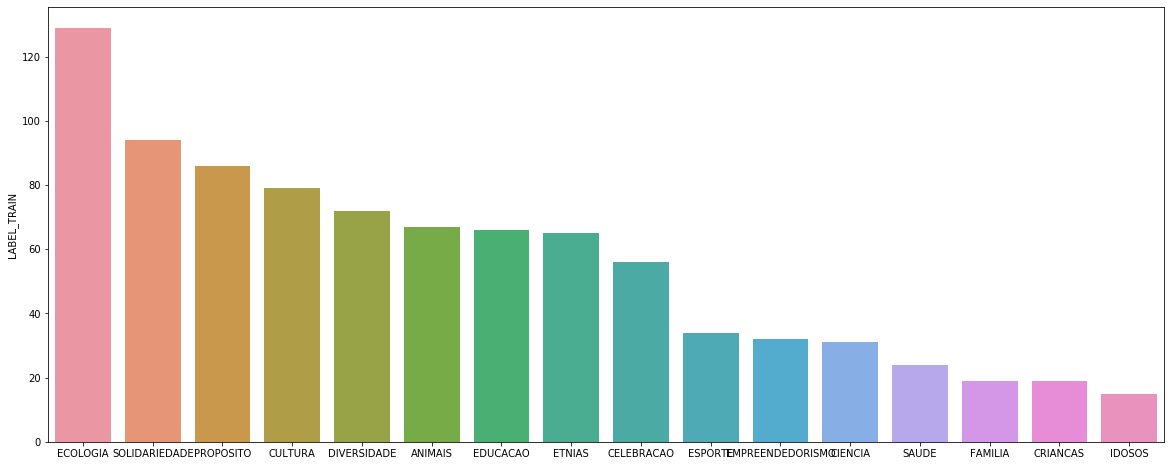

In [8]:
"""  Let"s see how the labels are distributed """
data_labels_count = df_ribon_news_treated[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
average_samples_per_label = data_labels_count.mean()
standard_deviation_for_labels = data_labels_count.std()
print("Mean number of samples for the target variable is: ", average_samples_per_label)
print("Standard deviation number of samples for the target variable is: ", standard_deviation_for_labels)


''' Numerical analysis
    One way to analyse the frequency of certain labels is to notice with they're too afar from the
    other labels frequencies average. Let's use standard deviation to check it'''
is_it_further_than_two_std_deviations = lambda x: "Warning"\
    if x > average_samples_per_label + standard_deviation_for_labels or \
        x < average_samples_per_label - standard_deviation_for_labels else "Okay"

for i in tqdm(range(0, len(data_labels), 2)):
    even_indexed_label = data_labels[i]
    odd_indexed_label = data_labels[i+1]
    
    print("{0:20}  {1:10} {2:15} {3:20} {4:10} {5:10}".format(
        even_indexed_label, data_labels_count[even_indexed_label], is_it_further_than_two_std_deviations(data_labels_count[even_indexed_label]),
        odd_indexed_label, data_labels_count[odd_indexed_label], is_it_further_than_two_std_deviations(data_labels_count[odd_indexed_label])))

''' Visual plotting'''
fig = plt.figure(figsize=(20, 8))
sns.barplot(
    x=data_labels_count.index,
    y=data_labels_count)
plt.show()

### Results

Based on the previous step, we can see the categories **ECOLOGIA** and **SOLIDARIEDADE** have **more than the average added by the standard deviation** which can cause the model to overly recognise those labels patterns and make then too sensitive for those. 

On other hand we have the categories **FAMILIA**, **CRIANCAS** and **IDOSOS** with **less than the average subtracted by the standard deviation** which can make the model too specific for those and hardly classify as it.

For now, let's try oversampling the least common labels by grouping then. When our pipeline is finely tunned we can use the grouped labels as input for another pipeline trainned only to discern among those.


['FAMILIA', 'CRIANCAS', 'IDOSOS']
ECOLOGIA            129
SOLIDARIEDADE        94
PROPOSITO            86
CULTURA              79
DIVERSIDADE          72
ANIMAIS              67
EDUCACAO             66
ETNIAS               65
CELEBRACAO           56
SCARCE_GROUP         53
ESPORTE              34
EMPREENDEDORISMO     32
CIENCIA              31
SAUDE                24
Name: LABEL_TRAIN, dtype: int64


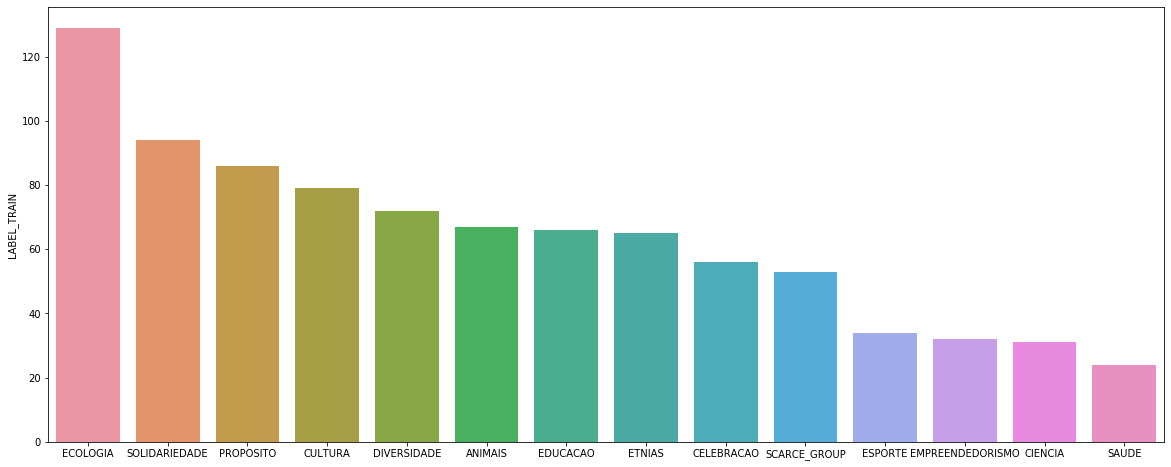

In [9]:
''' One possible approach is to group up under represented labels and further
    analyse it in other pipeline.  '''
data_labels_count = df_ribon_news_treated[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
under_represented_labels = [
    scarse_label
    for scarse_label in tqdm(data_labels)
    if data_labels_count[scarse_label] < average_samples_per_label - standard_deviation_for_labels]
print(under_represented_labels)

''' Now we have found which ones are under represented we'll create a new
    DataFrame changing the under represented to OUTROS '''
GROUP_TARGET_LABEL = 'SCARCE_GROUP'
df_ribon_news_grouped = df_ribon_news_treated.replace({TARGET_VARIABLE: under_represented_labels}, GROUP_TARGET_LABEL)
print(df_ribon_news_grouped[TARGET_VARIABLE].value_counts())

"""  Let"s see how the labels are distributed """
data_labels_count = df_ribon_news_grouped[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
fig = plt.figure(figsize=(20, 8))
sns.barplot(
    x=data_labels_count.index,
    y=data_labels_count)
plt.show()

### Storing partial progress

In [10]:
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_treated_grouped.xlsx"

In [11]:
"""  Let"s store the  data """
df_ribon_news_grouped.to_excel(excel_filename)

## Data Partition
Now we have treated the data structure and sampling problems. Let's drop unwanted columns.

In [12]:
"""  We then load the data for stability """
df_data = pd.read_excel(excel_filename, index_col=0)
print(df_data.head())

   ID  PICK_COUNT                                            CONTENT  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               TITLE    LABEL_TRAIN  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        ANIMAIS  
1  Muros da gentileza ajudam desabrigados e famíl...  SOLIDARIEDADE  
2  20 fotos maravilhosas mostrando a alegria de t...   SCARCE_GROUP  
3  13 razões pelas quais crianças são bem mais es...   SCARCE_GROUP  
4  Ex-executiva fala sobre vida sem propósito - I...      PROPOSITO  


In [13]:
""" As we have two possible text_variables, let's choose one for first analysis """
text_variable = POSSIBLE_TEXT_VARIABLES[0]
""" Dropping unwanted columns """
df_data = df_data[ [text_variable] + [TARGET_VARIABLE]]
print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 887
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CONTENT      886 non-null    object
 1   LABEL_TRAIN  888 non-null    object
dtypes: object(2)
memory usage: 20.8+ KB
None


### Dealing with missing values
As there are some samples without content, they'll not be useful to train or to validate the model. 
Hapilly they're not many so let's drop them.

In [14]:
df_data = df_data.dropna()
print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 887
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CONTENT      886 non-null    object
 1   LABEL_TRAIN  886 non-null    object
dtypes: object(2)
memory usage: 20.8+ KB
None


## Text Parsing(Preprocessing)

Before we train the model, it's necessary to tokenize words, find their lemmas and discard some words that could mislead the model.

Let's take a first look at the text variable.

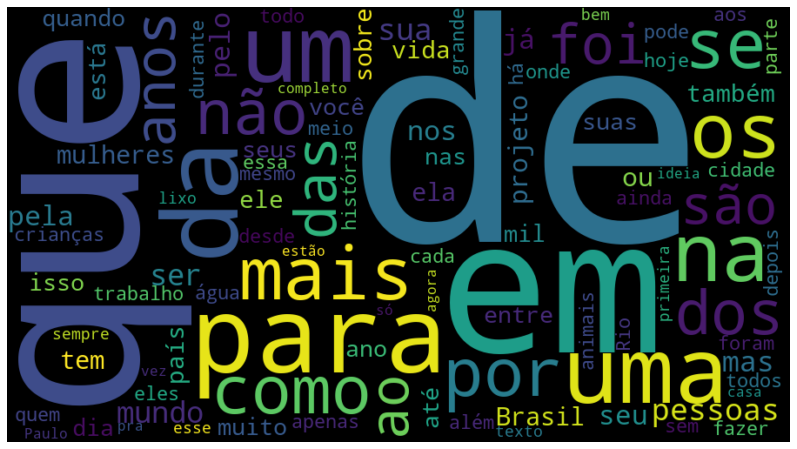

,       5186
de      4125
.       3196
a       2384
e       2370
o       1841
que     1814
do      1272
em      1213
da      1166
para    1144
um       897
uma      858
com      779
é        736
no       709
na       648
mais     534
os       527
A        451
as       432
por      417
se       417
como     408
O        400
dtype: int64


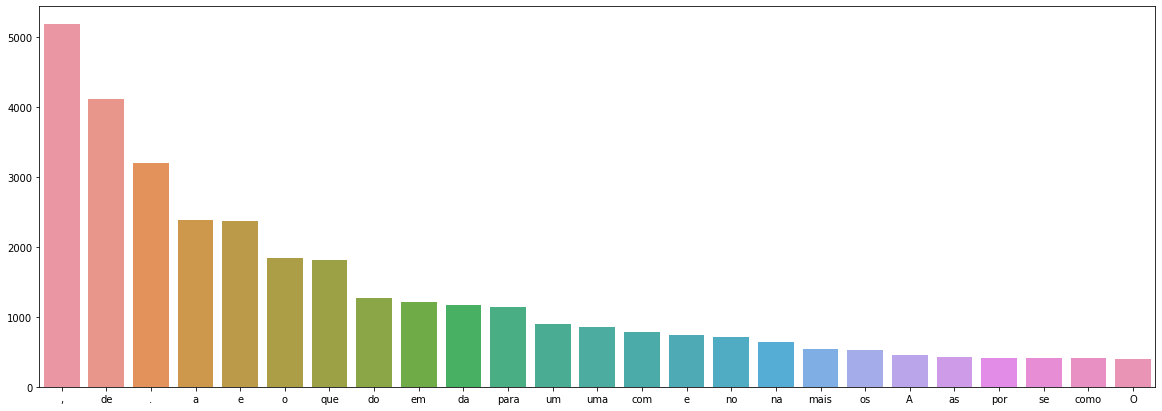

In [15]:
raw_text_column = df_data[text_variable]
generate_wordcloud(raw_text_column)
print(generate_freq_dist_plot(raw_text_column))

### Symbols and stopwords

As we can see, we have a lot of tokens from text variable being symbols or words that don't have by themselves much meaning. Let's fix that.
We can also strip trailing spaces and remove multiple spaces.

In [16]:
stopwords_set = set(STOP_WORDS).union(set(stopwords.words('portuguese')))
stopwords_string = str(stopwords_set)
stopword_pattern = r'\b(?:{})\b'.format('|'.join(stopwords_set)) 
symbols_pattern = '[^\w\s]'
space_pattern = r'\s{2,}'
print("This is the stopword pattern: ", stopword_pattern)
print()
print("This is the symbols pattern: ", symbols_pattern)

This is the stopword pattern:  \b(?:ou|essa|estivestes|nas|tenho|dentro|meses|dizer|iniciar|tal|houvéramos|sempre|for|quieto|deverá|terceiro|estão|tentar|tão|éramos|certeza|mesmo|números|põem|segundo|tais|irá|teríamos|estiveram|quando|fará|sob|dão|portanto|fossem|onze|são|meu|estive|somente|tivemos|dezoito|todo|conhecido|falta|sobre|formos|mais|boa|naquele|muitos|tuas|muito|no|vossas|sou|ambos|nos|houveremos|possível|direita|nesta|cedo|houverem|vos|uns|seu|somos|estás|breve|foi|tu|houveriam|tiveram|dá|tens|essas|das|havemos|sabe|catorze|tinha|tinham|há|através|tente|lado|aos|longe|fazia|pode|tipo|três|seis|tiverem|terei|forem|tenha|tudo|possivelmente|oito|coisa|do|não|todos|querem|às|vossa|tivessem|tem|esse|já|forma|caminho|fazem|para|sexto|estejam|aqueles|nove|é|bem|hão|apoia|temos|vem|assim|apenas|quinto|foste|corrente|eventual|sexta|atrás|desde|logo|deve|estes|delas|estou|outras|algumas|com|nossos|daquele|tarde|tivera|vêm|houvéssemos|esses|minhas|cima|nível|esteja|meio|fui|último|es

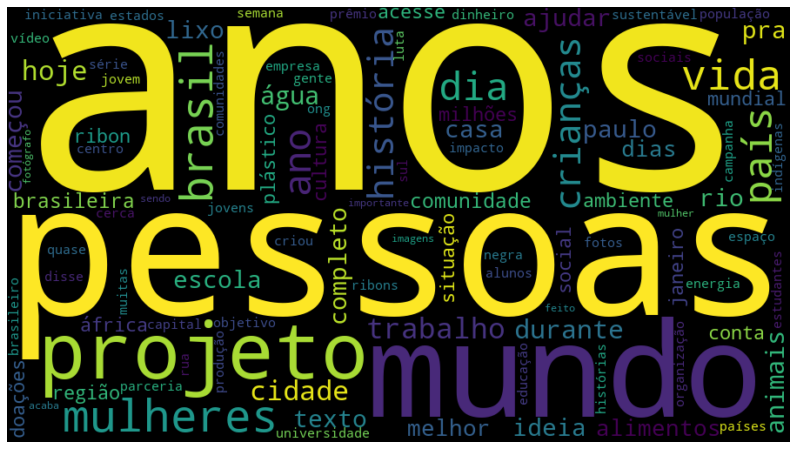

anos        319
pessoas     227
mundo       205
projeto     159
mulheres    152
brasil      151
vida        136
país        131
dia         118
ano         112
crianças    101
história     94
trabalho     88
cidade       85
hoje         82
durante      78
animais      75
água         75
rio          72
texto        72
lixo         70
completo     69
ideia        67
casa         66
pra          66
dtype: int64


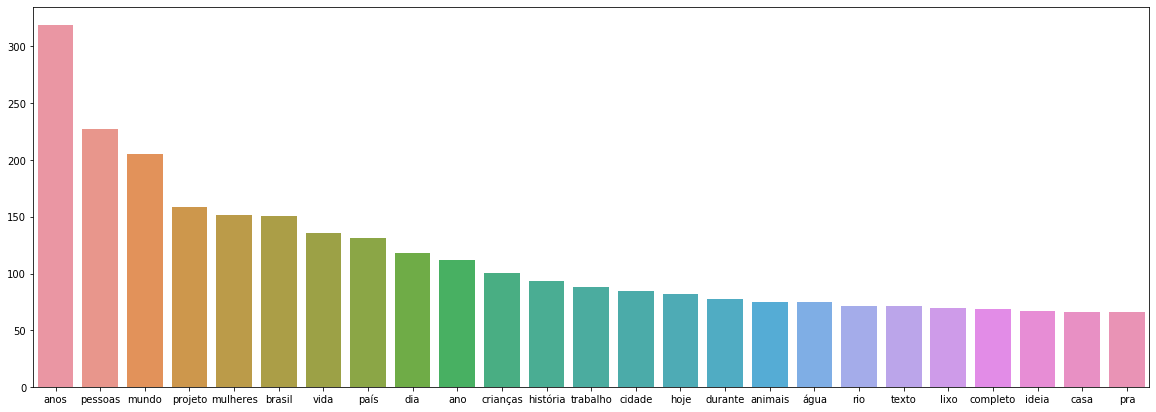

In [17]:
''' Processing text on caracteres level'''
df_data['PREPROCESSED_TEXT'] = df_data[text_variable].str.lower()
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(stopword_pattern, "")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(symbols_pattern, "")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(space_pattern, " ")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.strip()
generate_wordcloud(df_data['PREPROCESSED_TEXT'])
print(generate_freq_dist_plot(df_data['PREPROCESSED_TEXT']))

### Results
Now the most common words are way more expressive.

### Lemmatizing and stemming


Pipe already present.
['tagger', 'sentencizer', 'parser', 'ner']


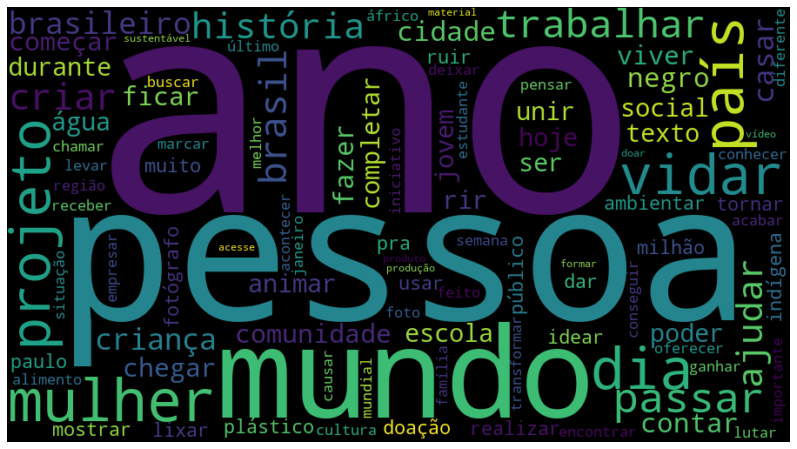

ano           431
pessoa        246
mundo         205
mulher        185
dia           178
país          171
projeto       159
vidar         157
passar        156
trabalhar     155
brasil        151
criar         139
ajudar        130
história      128
brasileiro    125
criança       121
casar         115
cidade        107
contar        103
negro         103
fazer         102
começar        98
viver          96
comunidade     94
ficar          91
dtype: int64


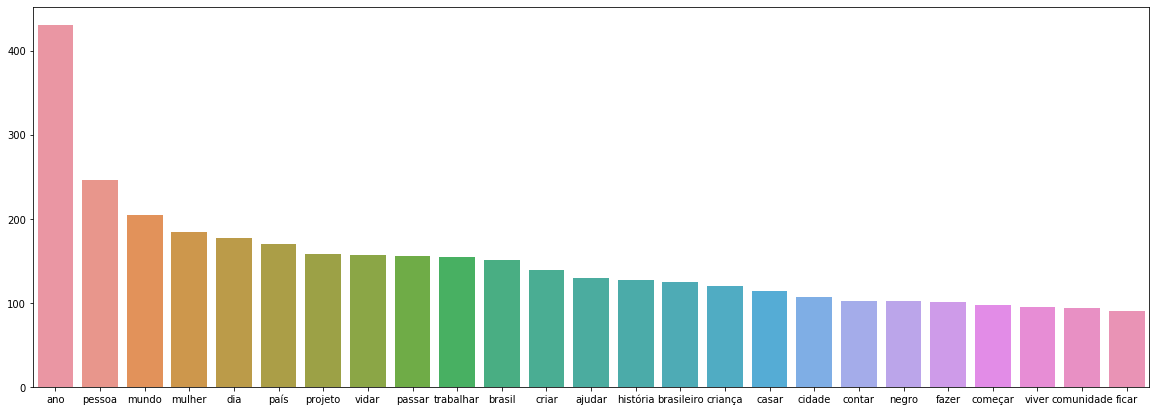

In [19]:
preprocessed_text_data = df_data['PREPROCESSED_TEXT'].to_list()
''' Not all variables are being undestood as strings so we have to force it'''

sentencizer = NLP_SPACY.create_pipe('sentencizer')
''' Create the pipeline 'sentencizer' component '''

try:
    ''' We then add the component to the pipeline if we hadn't done before '''
    NLP_SPACY.add_pipe(sentencizer, before='parser')
except ValueError:
    print("Pipe already present.")

print(NLP_SPACY.pipe_names)

lemmatized_doc = []
for row in tqdm(preprocessed_text_data):
    doc = NLP_SPACY(row)
    lemmatized_doc.append(" ".join([word.lemma_ for word in doc]))
    
df_data['LEMMATIZED_DOC'] = lemmatized_doc

generate_wordcloud(df_data['LEMMATIZED_DOC'])
print(generate_freq_dist_plot(df_data['LEMMATIZED_DOC']))

### Storing partial progress

In [20]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_preprocessed_data.xlsx"

In [21]:
df_data.to_excel(excel_filename)

 ## Text Filter(Counting and vectorizing)
 Now we have clear tokens we can measure how much they affect the outcome prediction and how many of them exist in each sample.

In [22]:
"""  We then load the data for stability """
df_processed_data = pd.read_excel(excel_filename, index_col=0)
print(df_processed_data.head())

                                             CONTENT    LABEL_TRAIN  \
0  A forte ligação dos cães com o ser humano desp...        ANIMAIS   
1  Os chamados muros da gentileza estão promovend...  SOLIDARIEDADE   
2  Alguns de nós sabem a sorte que é ter um irmão...   SCARCE_GROUP   
3               Temos muito o que aprender com elas.   SCARCE_GROUP   
4  Esqueça o que te disseram sobre a zona de conf...      PROPOSITO   

                                   PREPROCESSED_TEXT  \
0  forte ligação cães humano desperta muita curio...   
1  chamados muros gentileza promovendo doação rou...   
2  sabem sorte irmão irmã quão maravilhoso sensaç...   
3                                           aprender   
4  esqueça disseram zona conforto mentira existe ...   

                                      LEMMATIZED_DOC  
0  forte ligação cão humanar desperto muito curio...  
1  chamar muro gentileza promover doação roupar m...  
2  saber sortir irmão irmão quão maravilhoso sens...  
3               

In [23]:
''' Best parameter using GridSearch (CV score=0.535):
{'clf__alpha': 1e-05, 'clf__max_iter': 80, 'clf__penalty': 'l2', 'tfidf__norm': 'l1',
'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__ngram_range': (1, 2)}
'''
''' Text Parser
    This part is responsible to give weights to important tokens and remove
    weight for unwanted ones or those who can be misguiding.
    - Frequency Counter
    - Id-IdF Counter
'''
count_vectorizer = CountVectorizer(
    max_features=None, max_df=0.5, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf='True')

''' Let's transform the lemmatized documents into count vectors '''
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['LEMMATIZED_DOC'])

''' Then use those count vectors to generate frequency vectors '''
frequency_vectors = tfidf_transformer.fit_transform(count_vectors)
print(frequency_vectors)

  (0, 28494)	0.07555686430111903
  (0, 27509)	0.07555686430111903
  (0, 27497)	0.03848247545756805
  (0, 24657)	0.07555686430111903
  (0, 24655)	0.06579858333931186
  (0, 21078)	0.07555686430111903
  (0, 21074)	0.05409862064407664
  (0, 18635)	0.07555686430111903
  (0, 18617)	0.04865844779740469
  (0, 12918)	0.07555686430111903
  (0, 12917)	0.07555686430111903
  (0, 11884)	0.07555686430111903
  (0, 11870)	0.04909319244568377
  (0, 11754)	0.07555686430111903
  (0, 11750)	0.0638569016058838
  (1, 43663)	0.032122747489209284
  (1, 43661)	0.02546554392828383
  (1, 39309)	0.03406985471061365
  (1, 39307)	0.029669682500327872
  (1, 38490)	0.023258797406551453
  (1, 38467)	0.018154612255142717
  (1, 37100)	0.03406985471061365
  (1, 37072)	0.01798308840468436
  (1, 37026)	0.03406985471061365
  (1, 37009)	0.022136942147821102
  :	:
  (885, 3598)	0.006932804715175339
  (885, 3514)	0.0066346474048068465
  (885, 3401)	0.004245253738062082
  (885, 3222)	0.00735303384190364
  (885, 3212)	0.005413074

In [26]:
''' Model Train and Evaluation
'''

clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')
pipeline_simple = Pipeline([
    ('clf', clf)
])
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])
''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    frequency_vectors,
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for explicit pipeline: ", scores.mean())

scores = cross_val_score(
    pipeline,
    df_processed_data['LEMMATIZED_DOC'],
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for implicit pipeline: ", scores.mean())

Mean accuracy for explicit pipeline:  0.5022727272727273
Mean accuracy for implicit pipeline:  0.5248340143003064


In [27]:
''' Let's evaluate more deeply the best model '''
X_train, X_test, y_train, y_test = train_test_split(
    df_processed_data['LEMMATIZED_DOC'],
    df_processed_data[TARGET_VARIABLE],
    test_size=0.33, random_state=42)

train1 = X_train.tolist()
labelsTrain1 = y_train.tolist()
test1 = X_test.tolist()
labelsTest1 = y_test.tolist()
"""  train """
pipeline.fit(train1, labelsTrain1)
"""  test """
preds = pipeline.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print(
    classification_report(
        labelsTest1,
        preds,
        target_names=df_processed_data[TARGET_VARIABLE].unique()))

accuracy: 0.515358361774744
                  precision    recall  f1-score   support

         ANIMAIS       0.87      0.83      0.85        24
   SOLIDARIEDADE       0.40      0.21      0.28        19
    SCARCE_GROUP       0.33      0.14      0.20         7
       PROPOSITO       0.47      0.47      0.47        30
     DIVERSIDADE       0.62      0.30      0.40        27
        EDUCACAO       0.60      0.80      0.69        40
        ECOLOGIA       0.39      0.55      0.45        22
           SAUDE       0.40      0.20      0.27        10
         CIENCIA       0.50      0.78      0.61         9
      CELEBRACAO       0.23      0.39      0.29        18
          ETNIAS       0.85      0.65      0.73        34
         ESPORTE       0.00      0.00      0.00         8
         CULTURA       0.43      0.33      0.38        18
EMPREENDEDORISMO       0.41      0.59      0.48        27

        accuracy                           0.52       293
       macro avg       0.46      0.45     